# Number of U.S. Undocumented Immigrants Apprehended and Deported
## Load Data

In [1]:
# Load data
app <- read.csv('immigration_apprehended.csv')
dep <- read.csv('immigration_deported.csv')

## Time Series Plot of Immigrants Apprehended

In [2]:
# Dataset is backwards, need to reverse it
year.num <- rev(app[,1])
num <- rev(app[,2])

### Plot Time Series

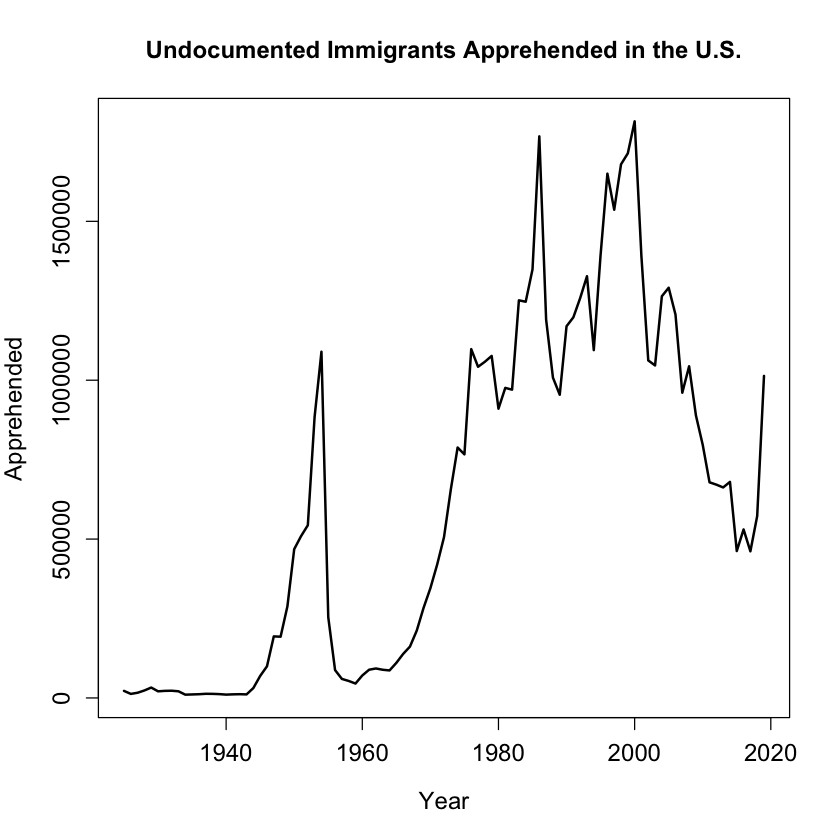

In [3]:
plot(year.num, num, type='l', xlab='Year', ylab='Apprehended', lwd=2,
     cex.axis=1.2, cex.lab=1.2, main='Undocumented Immigrants Apprehended in the U.S.')

### Check for Stationarity

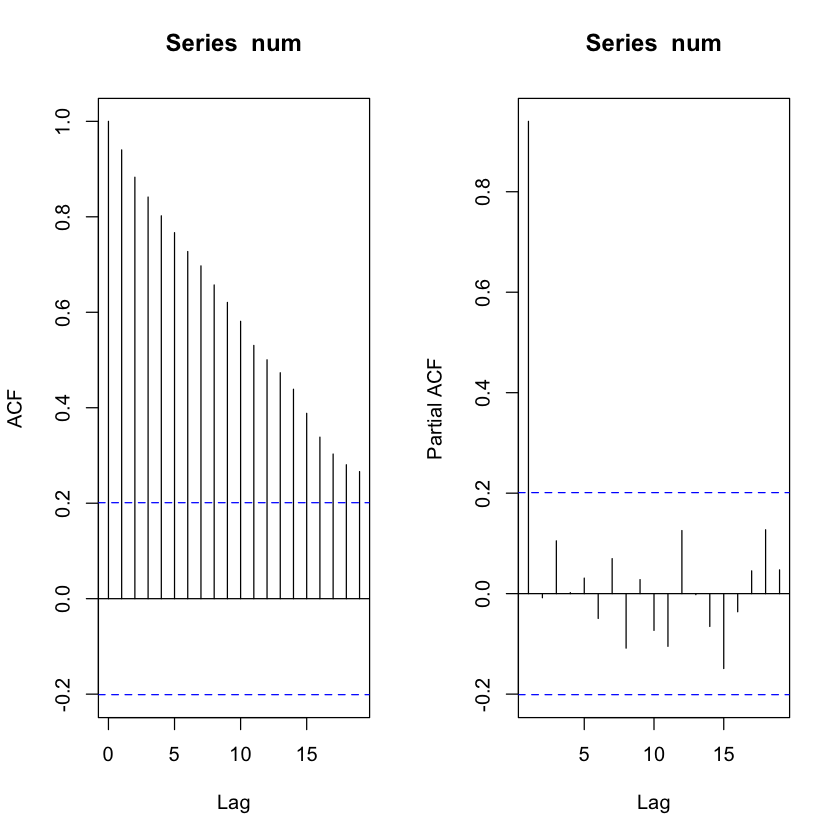

In [4]:
par(mfrow=c(1,2))
acf(num)
pacf(num)

### Check for Constant Variance
If lambda=0, a log transformation is not needed.

In [5]:
# Load library for Box-Cox lambda
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [6]:
# Check lambda value. If lambda=0, a log transformation is needed.
# Log transformation not needed.
BoxCox.lambda(num) # -0.139
# First check the 95% confidence interval

[1] -0.1394607

### Check for Constant Mean

In [7]:
# Load library for Augmented Dickey-Fuller unit-root test
library(tseries)
adf.test(num) # Data is not stationary (has a unit root)


	Augmented Dickey-Fuller Test

data:  num
Dickey-Fuller = -1.9355, Lag order = 4, p-value = 0.603
alternative hypothesis: stationary


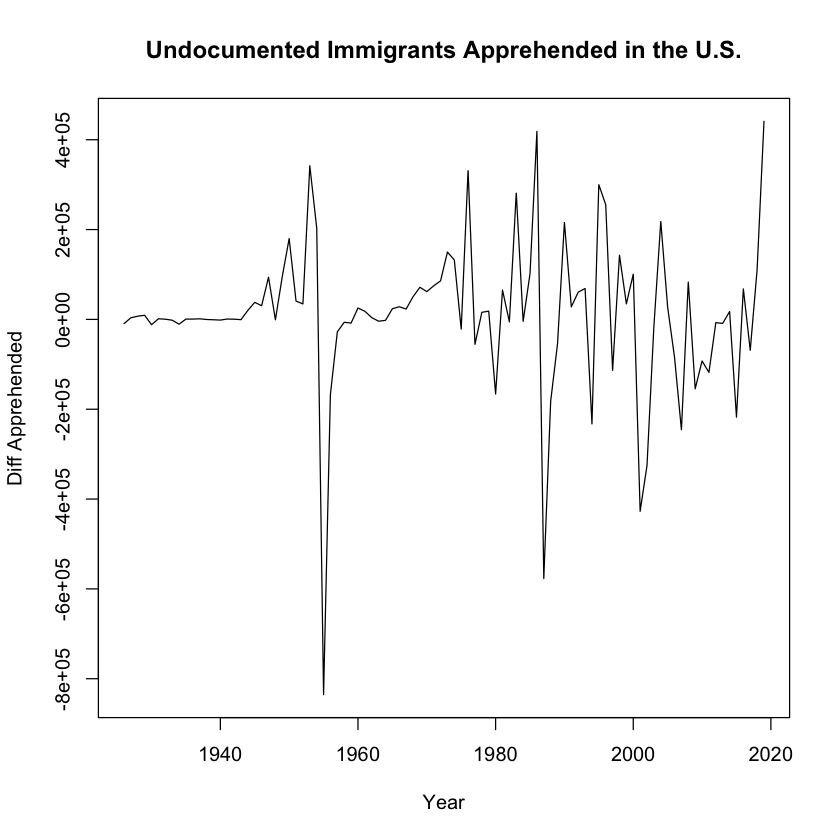

In [8]:
dnum <- diff(num) # Take the difference
par(mfrow=c(1,1))
plot(year.num[-1], dnum, type='l', xlab='Year', ylab='Diff Apprehended',
     main='Undocumented Immigrants Apprehended in the U.S.')

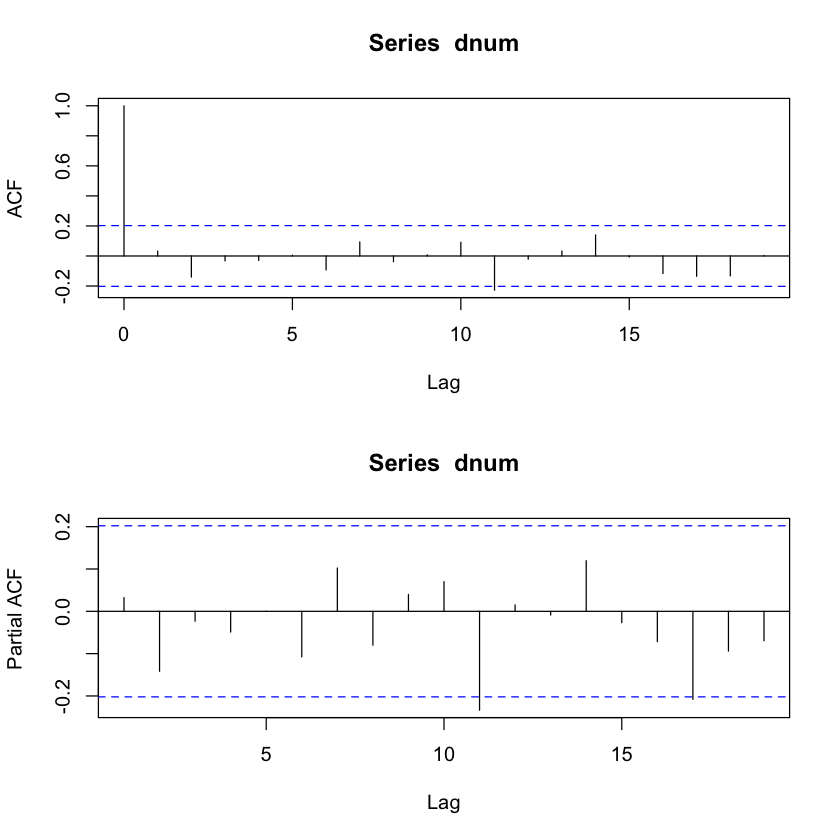

In [9]:
# ACF and PACF
par(mfrow=c(2,1))
acf(dnum)
pacf(dnum)

In [10]:
adf.test(dnum) # Data is stationary

Warning message in adf.test(dnum):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  dnum
Dickey-Fuller = -4.3563, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


## Time Series Plot of Immigrants Deported

In [11]:
# Define columns
year.dep <- rev(dep[,1])
rem <- rev(dep[,2])
ret <- rev(dep[,3])
# Remove NA in return column
ret <- na.omit(ret)

### Plot Time Series

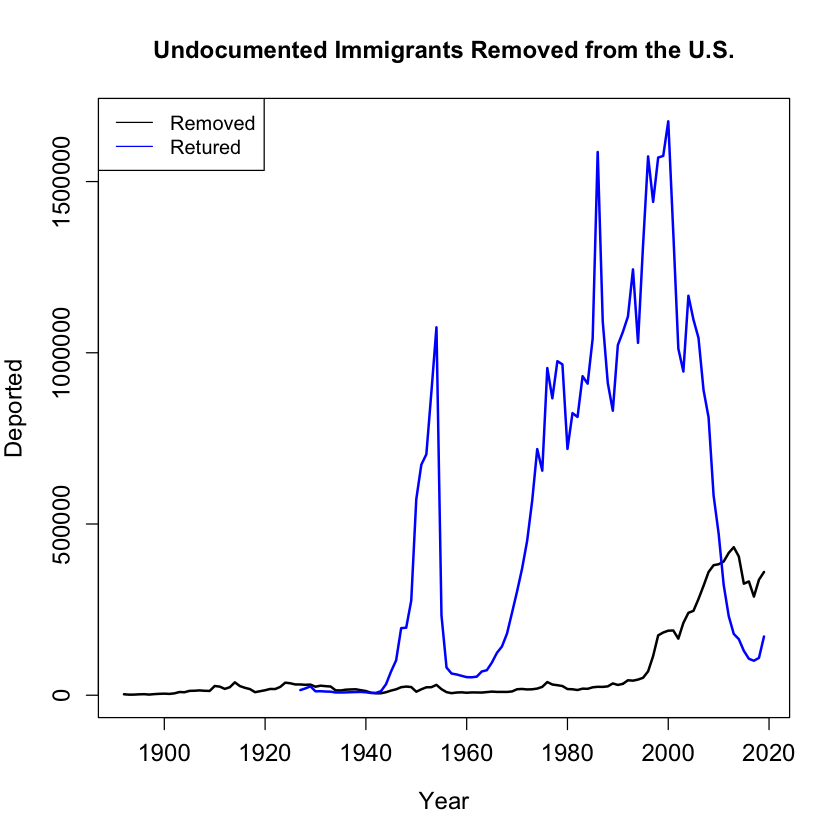

In [12]:
par(mfrow=c(1,1))
plot(year.dep, rem, type='l', xlab='Year', ylab='Deported', lwd=2,
     cex.axis=1.2, cex.lab=1.2, xlim=range(year.dep), ylim=range(c(rem, ret)),
     main='Undocumented Immigrants Removed from the U.S.')
lines(year.dep[36:128], ret, type='l', col='blue', lwd=2)
legend("topleft", legend=c("Removed", "Retured"), col=c('black', 'blue'),
       lty=1:1)

### Check for Stationarity

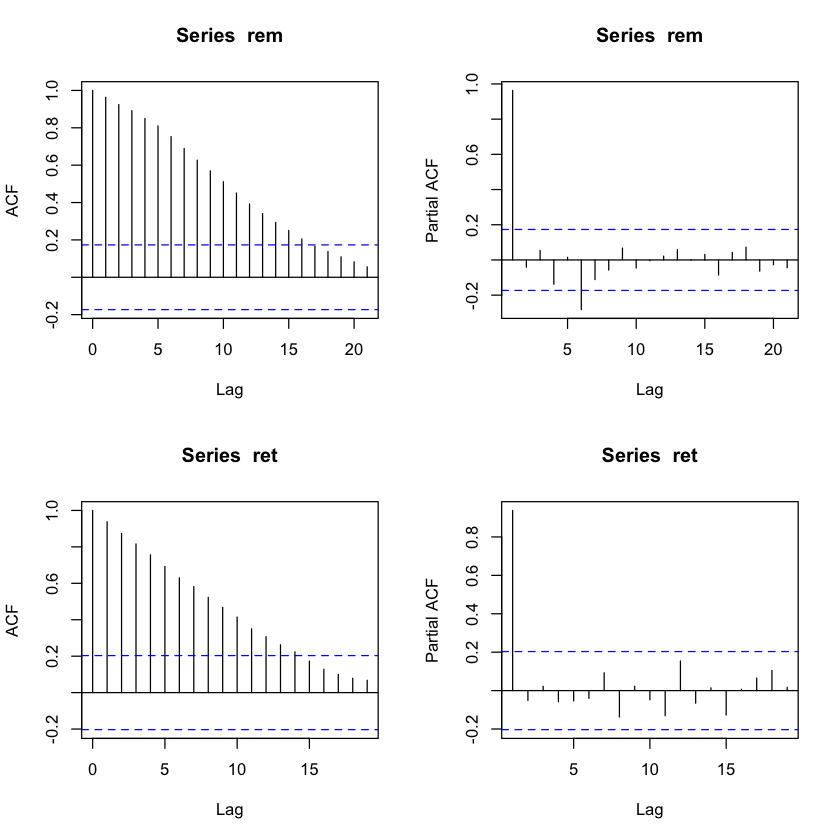

In [13]:
par(mfrow=c(2,2))
# Removed data series
acf(rem)
pacf(rem)
# Returned data series
acf(ret)
pacf(ret)

### Check for Constant Variance
If lambda=0, a log transformation is not needed.

In [14]:
# Check for for constant variance
BoxCox.lambda(rem) # 0.172
BoxCox.lambda(ret) # -0.042 - Need to apply log

[1] 0.1719225

[1] -0.04194611

In [15]:
# Apply log transformation
logret <- log(ret)

### Check for Constant Mean

In [16]:
# Augmented Dickey-Fuller unit root test
adf.test(rem) # Data is not stationary (has a unit root)
adf.test(logret) # Data is not stationary (has a unit root)


	Augmented Dickey-Fuller Test

data:  rem
Dickey-Fuller = -1.0015, Lag order = 5, p-value = 0.9346
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  logret
Dickey-Fuller = -2.5817, Lag order = 4, p-value = 0.3364
alternative hypothesis: stationary


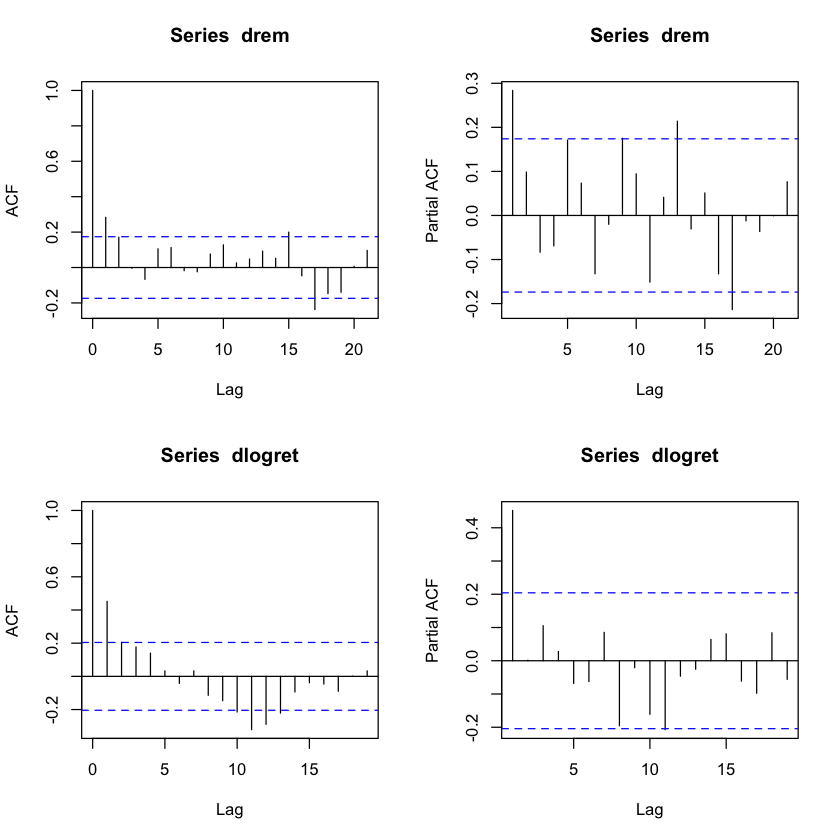

In [17]:
# Difference the data
drem <- diff(rem)
dlogret <- diff(logret)
par(mfrow=c(2,2))
acf(drem)
pacf(drem)
acf(dlogret)
pacf(dlogret)

In [18]:
# Check again
adf.test(drem) # Data is stationary
adf.test(dlogret) # Data is stationary


	Augmented Dickey-Fuller Test

data:  drem
Dickey-Fuller = -3.5154, Lag order = 5, p-value = 0.04378
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  dlogret
Dickey-Fuller = -3.565, Lag order = 4, p-value = 0.04066
alternative hypothesis: stationary


## Determine the Model

In [19]:
# Load TSA library
# This library won't load for eacf()
library(TSA)

ERROR: Error in library(TSA): there is no package called ‘TSA’


In [ ]:
# EACF doesn't work on Jupyter Notebooks
eacf(dnum) # ARMA(3,2)
eacf(drem) # MA(1)
eacf(dlogret) # AR(1)

## Build Models

In [20]:
# Apprehended dataset
arma <- arima(dnum, order = c(3, 0, 2))
arma


Call:
arima(x = dnum, order = c(3, 0, 2))

Coefficients:
         ar1     ar2     ar3      ma1      ma2  intercept
      0.3002  0.5091  0.0181  -0.3037  -0.6963  13022.939
s.e.  0.3074  0.3243  0.1219   0.2900   0.2892   4880.557

sigma^2 estimated as 2.773e+10:  log likelihood = -1264.47,  aic = 2542.94

In [21]:
# Removed dataset
ma <- arima(drem, order = c(0, 0, 1))
ma


Call:
arima(x = drem, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.2228   2817.769
s.e.  0.0751   1583.083

sigma^2 estimated as 213453597:  log likelihood = -1398.09,  aic = 2802.19

In [22]:
# Returned dataset
ar <- arima(dlogret, order = c(1, 0, 0))
ar


Call:
arima(x = dlogret, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.4585     0.0326
s.e.  0.0930     0.0564

sigma^2 estimated as 0.08736:  log likelihood = -18.52,  aic = 43.05

## Residual Analysis

In [23]:
Box.test(arma$residuals, lag=12, type="Ljung") # Residual series is white noise
Box.test(ma$residuals, lag=12, type="Ljung") # Residual series is white noise
Box.test(ar$residuals, lag=12, type="Ljung") # Residual series is white noise


	Box-Ljung test

data:  arma$residuals
X-squared = 8.7912, df = 12, p-value = 0.7207



	Box-Ljung test

data:  ma$residuals
X-squared = 10.67, df = 12, p-value = 0.5574



	Box-Ljung test

data:  ar$residuals
X-squared = 12.719, df = 12, p-value = 0.3898


## Check for Significance
### Immigrants Apprehended

In [24]:
# Load lmtest library
library(lmtest)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [25]:
coeftest(arma) # Model selected
arma1 <- arima(dnum, order = c(3, 0, 2), fixed = c(0, 0, 0, 0, NA, NA))
coeftest(arma1) # Variables are not significant for this model


z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)   
ar1        3.0017e-01  3.0745e-01  0.9763 0.328894   
ar2        5.0915e-01  3.2429e-01  1.5700 0.116408   
ar3        1.8089e-02  1.2185e-01  0.1484 0.881989   
ma1       -3.0372e-01  2.8996e-01 -1.0475 0.294888   
ma2       -6.9628e-01  2.8919e-01 -2.4077 0.016053 * 
intercept  1.3023e+04  4.8806e+03  2.6683 0.007623 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Warning message in arima(dnum, order = c(3, 0, 2), fixed = c(0, 0, 0, 0, NA, NA)):
“some AR parameters were fixed: setting transform.pars = FALSE”



z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)
ma2          -0.17026     0.11320 -1.5041   0.1326
intercept  9647.96092 14689.82440  0.6568   0.5113


### Immigrants Removed

In [26]:
coeftest(ma)
ma1 <- arima(drem, order = c(0, 0, 1), fixed = c(NA, 0))
coeftest(ma1)


z test of coefficients:

            Estimate Std. Error z value Pr(>|z|)   
ma1       2.2284e-01 7.5104e-02  2.9671 0.003006 **
intercept 2.8178e+03 1.5831e+03  1.7799 0.075088 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)   
ma1 0.237412   0.074489  3.1872 0.001437 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [27]:
# Check AIC
ma$aic # Model selected
ma1$aic

[1] 2802.185

[1] 2803.276

### Immigrants Returned

In [28]:
coeftest(ar)
ar1 <- arima(dlogret, order = c(1, 0, 0), fixed = c(NA, 0))
coeftest(ar1)


z test of coefficients:

          Estimate Std. Error z value  Pr(>|z|)    
ar1       0.458533   0.093028  4.9290 8.266e-07 ***
intercept 0.032649   0.056439  0.5785    0.5629    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1  0.46159    0.09304  4.9612 7.006e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
# Check AIC
ar$aic
ar1$aic # Model selected

[1] 43.04792

[1] 41.38141

## Check Stationarity (Calculating the Root)

In [30]:
# ARMA(3,2) model for apprehended immigrants
# Difference the data
arma$coef
polyroot(c(1, -arma$coef[1:3]))
abs(polyroot(c(1, -arma$coef[1:3]))) # Model is stationary
polyroot(c(1, arma$coef[4:5])) # No root matches

ar1           ar2           ar3           ma1           ma2 
 3.001735e-01  5.091470e-01  1.808899e-02 -3.037222e-01 -6.962764e-01 
    intercept 
 1.302294e+04

[1]   1.119813-0i  -1.797176+0i -27.469426-0i

[1]  1.119813  1.797176 27.469426

[1]  1.000001-0i -1.436210+0i

In [31]:
# MA(1) model for removed immigrants is automatically stationary

In [32]:
# AR(1) model for returned immigrants
polyroot(c(1, -ar1$coef[1]))
abs(polyroot(c(1, -ar1$coef[1]))) # Model is stationary

[1] 2.166429+0i

[1] 2.166429

## Forecasting
### Apprehended Immigrants

In [33]:
# Add back the difference order
arma2 <- arima(num, order = c(3, 1, 2))
coeftest(arma2) # Model selected
arma3 <- arima(num, order=c(3, 1, 2), fixed=c(0, 0, 0, 0, NA))
coeftest(arma3) # Variables are not significant for this model


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)  
ar1  0.263578   0.419399  0.6285  0.52970  
ar2  0.478649   0.348680  1.3727  0.16983  
ar3  0.025797   0.144078  0.1790  0.85790  
ma1 -0.225305   0.405742 -0.5553  0.57870  
ma2 -0.631812   0.297655 -2.1226  0.03378 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Warning message in arima(num, order = c(3, 1, 2), fixed = c(0, 0, 0, 0, NA)):
“some AR parameters were fixed: setting transform.pars = FALSE”



z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)
ma2 -0.16671    0.11287  -1.477   0.1397


In [34]:
# Difference order added back
pp <- predict(arma2, 5) # Predict the next quarters in 2009
nn <- length(num)	# Length of your data
nt <- 5	# Forecast horizon
nb <- 20 # Number of data points you want to plot
tt <- (nn-nb):nn # Indexes of data points you want to plot
xxx <- num[tt]	# Data you want to plot
rr <- range(c(xxx, pp$pred, pp$pred+2*pp$se,
              pp$pred-2*pp$se)) # Find the minimum and maximum y values in your plot
year.num <- seq(1925, 2024)

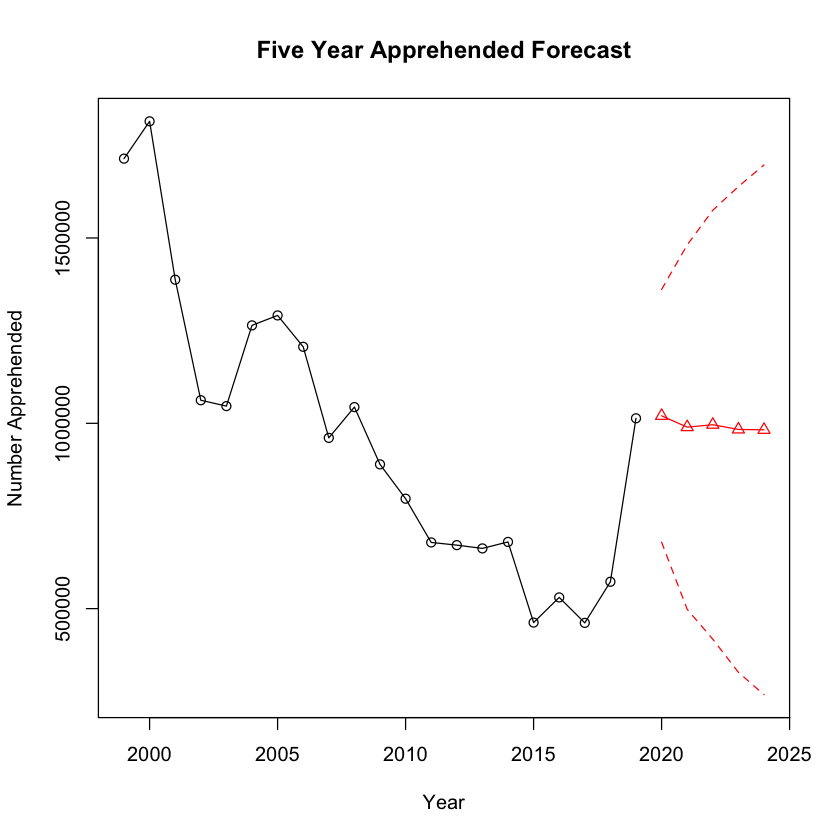

In [35]:
# Plot the data and prediction
par(mfrow=c(1,1))
plot(year.num[tt], xxx, pch=1, xlim=c(year.num[nn-nb], year.num[nn+nt]), ylim=rr,
     main='Five Year Apprehended Forecast',
     ylab='Number Apprehended', xlab='Year')
lines(year.num[tt], xxx)	# Observed values
points(year.num[nn+1:nt], pp$pred, pch=2, col='red', type='o')	# Predicted values
lines(year.num[nn+1:nt], pp$pred+2*pp$se, lty=2, col='red')	# Upper bound of predicted interval
lines(year.num[nn+1:nt], pp$pred-2*pp$se, lty=2, col='red')	# Lower bound of predicted interval

### Deported Immigrants (Removed & Returned)

#### Add Back the Differenced Order

In [36]:
# Add back the difference order
ma2 <- arima(rem, order=c(0, 1, 1))
coeftest(ma2)

ar2 <- arima(logret, order = c(1, 1, 0))
coeftest(ar2)


z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)   
ma1 0.237412   0.074489  3.1872 0.001436 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1  0.46159    0.09304  4.9612 7.006e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### Set Up Variables

In [37]:
# Removed immigrants
pp <- predict(ma2, 5) # Predict the next quarters in 2009
nn <- length(rem)	# Length of your data
nt <- 5	# Forecast horizon
nb <- 20 # Number of data points you want to plot
tt <- (nn-nb):nn # Indexes of data points you want to plot
xxx <- rem[tt]	# Data you want to plot
rr <- range(c(xxx, pp$pred, pp$pred+2*pp$se,
              pp$pred-2*pp$se)) # Find the minimum and maximum y values in your plot
year.dep <- seq(1892, 2024)

In [38]:
# Returned immigrants
pp1 <- predict(ar2, 5) # Predict the next quarters in 2009
nn1 <- length(logret)	# Length of your data
nt1 <- 5	# Forecast horizon
nb1 <- 20 # Number of data points you want to plot
tt1 <- (nn1-nb1):nn1 # Indexes of data points you want to plot
xxx1 <- ret[tt1]	# Data you want to plot
pred <- exp(pp1$pred) # Prediction
pred.upp <- exp(pp1$pred+2*pp1$se)  # Upper bound for prediction
pred.low <- exp(pp1$pred-2*pp1$se)  # Lower bound for prediction
rr1 <- range(c(xxx1, pred, pred.upp, pred.low)) # Find the minimum and maximum y values in your plot

#### Plot the Data and Prediction

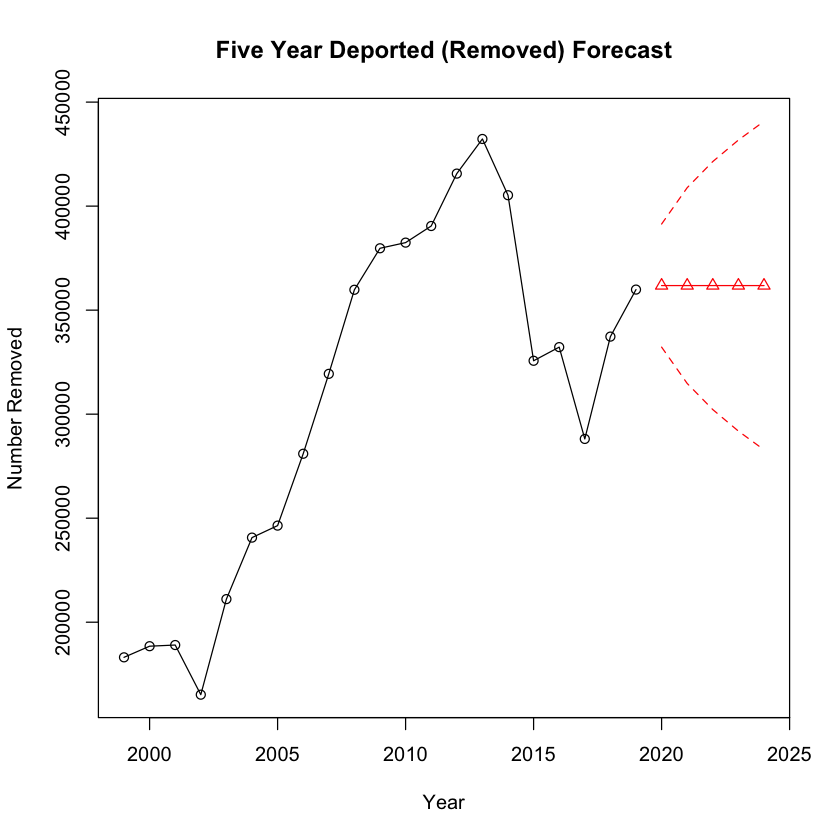

In [39]:
# Removed immigrants
plot(year.dep[tt], xxx, pch=1, xlim=c(year.dep[nn-nb], year.dep[nn+nt]),
     ylim=rr, main='Five Year Deported (Removed) Forecast',
     ylab='Number Removed', xlab='Year')
lines(year.dep[tt], xxx)	# Observed values
points(year.dep[nn+1:nt], pp$pred, pch=2, col='red', type='o')	# Predicted values
lines(year.dep[nn+1:nt], pp$pred+2*pp$se, lty=2, col='red')	# Upper bound of predicted interval
lines(year.dep[nn+1:nt], pp$pred-2*pp$se, lty=2, col='red')	# Lower bound of predicted interval

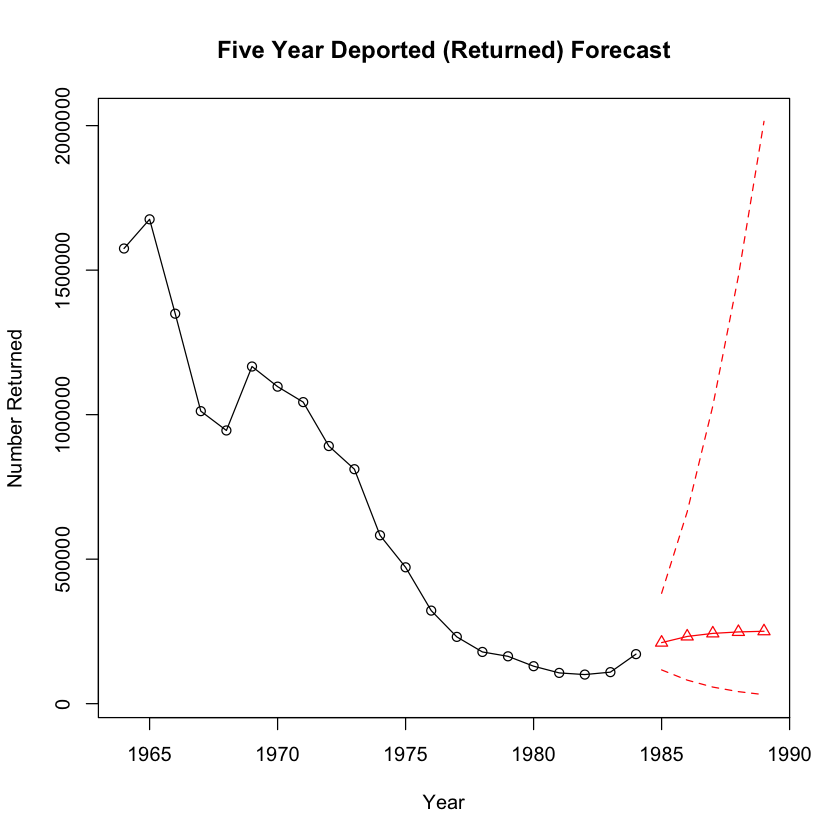

In [40]:
# Returned immigrants
plot(year.dep[tt1], xxx1, pch=1, xlim=c(year.dep[nn1-nb1], year.dep[nn1+nt1]),
     ylim=rr1, main='Five Year Deported (Returned) Forecast',
     ylab='Number Returned', xlab='Year')
lines(year.dep[tt1], xxx1)	# Observed values
points(year.dep[nn1+1:nt1], pred, pch=2, col='red', type='o')	# Predicted values
lines(year.dep[nn1+1:nt1], pred.upp, lty=2, col='red')	# Upper bound of predicted interval
lines(year.dep[nn1+1:nt1], pred.low, lty=2, col='red')	# Lower bound of predicted interval

## Multivariate Time Series

In [41]:
# Load the vars library
library(vars)

Loading required package: MASS

Loading required package: strucchange

Loading required package: sandwich

Loading required package: urca



In [42]:
# Adjust variables and remove NA rows
# This data subset should have a value for each of the variable at a year
app <- app[1:93,]
num <- rev(app[,2])
dep <- dep[1:93,]
rem <- rev(dep[,2])
ret <- rev(dep[,3])
x <- cbind(num, rem, ret)

In [43]:
# Vector Autoregressive Model - VAR
var <- VAR(x, p=1)
summary(var)


VAR Estimation Results:
Endogenous variables: num, rem, ret 
Deterministic variables: const 
Sample size: 92 
Log Likelihood: -3387.267 
Roots of the characteristic polynomial:
0.9895 0.9672 0.9672
Call:
VAR(y = x, p = 1)


Estimation results for equation num: 
num = num.l1 + rem.l1 + ret.l1 + const 

         Estimate Std. Error t value Pr(>|t|)    
num.l1     1.2524     0.2021   6.198  1.8e-08 ***
rem.l1    -0.3253     0.2213  -1.470   0.1452    
ret.l1    -0.3183     0.2093  -1.521   0.1318    
const  48449.0075 28250.4532   1.715   0.0899 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 173400 on 88 degrees of freedom
Multiple R-Squared: 0.901,	Adjusted R-squared: 0.8976 
F-statistic: 266.8 on 3 and 88 DF,  p-value: < 2.2e-16 


Estimation results for equation rem: 
rem = num.l1 + rem.l1 + ret.l1 + const 

         Estimate Std. Error t value Pr(>|t|)    
num.l1 -5.107e-02  1.893e-02  -2.697  0.00839 ** 
rem.l1  1.052e+00  2.074e-02

In [44]:
# Determine p
VARselect(x, lag.max=6) # p = 1 selected

,1,2,3,4,5,6
AIC(n),6.555966e+01,6.568110e+01,6.576190e+01,6.583468e+01,6.557383e+01,6.570727e+01
HQ(n),6.569662e+01,6.592078e+01,6.610429e+01,6.627979e+01,6.612166e+01,6.635782e+01
SC(n),6.589979e+01,6.627632e+01,6.661221e+01,6.694008e+01,6.693433e+01,6.732287e+01
FPE(n),2.966775e+28,3.352686e+28,3.642157e+28,3.931646e+28,3.046958e+28,3.512534e+28


In [45]:
# Portmanteau test
serial.test(var) # Residuals are white noise


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var
Chi-squared = 138.51, df = 135, p-value = 0.4004

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var
Chi-squared = 138.51, df = 135, p-value = 0.4004

